In [1]:
import datetime
import pyaurorax
import cartopy.crs
import pprint

aurorax = pyaurorax.PyAuroraX()
at = aurorax.tools

# Create TREx RGB mosaic

The process of making a mosaic involves properly accounting for the mapping of each pixel. Due to the fisheye optics, the pixels become increasingly large as you move away from zenith, to lower elevation angles.

Our methodology for creating mosaics relies on two key points.

we must accurately account for the changing (and unique) pixel areas and locations in geodetic coordinates, and
when putting multiple imagers together, we want to use the information from the closest camera
Our methodology involves creating exact polygons for each pixel (this is why the skymap contains the pixel corners!), for each camera and filling those polygons with the correct (scaled, or calibrated) imager data. This methodology ensures accuracy of all pixels within the FoV.

The procedure for making a mosaic is best done in 1D vector space. Below you will find functions that convert the skymaps and images to vectors, before plotting those vectors.


### Note

In general, before building a mosaic you'll want to verify what sites you should use by looking at the summary data. In this case, the summary data clearly shows that Fort Smith had a different color profile than the other RGB cameras. The data is still useable, however in multi-imager studies Fort Smith's instrument response cannot be directly intercompared with, for example Rabbit, because of the color offset. This was an operational issue at Fort Smith.

For this event, it is far more advantageous to use Yellowknife (a recent installation of RGB) which has singificant overlap with Fort Smith but did not have the color profile issue.



## Step 1: Download and read image data

Pay attention to the order of the sites here is very important, as that order MUST be the same for both the skymap and image data we pass into the mosaic prep routines.

In [2]:
# download a minute of TREx RGB data from several sites
dataset_name = "TREX_RGB_RAW_NOMINAL"
dt = datetime.datetime(2023, 2, 24, 6, 15)
site_uid_list = ["yknf", "gill", "rabb", "luck", "atha"]
data_list = []
for site_uid in site_uid_list:
    r = aurorax.data.ucalgary.download(dataset_name, dt, dt, site_uid=site_uid)
    data = aurorax.data.ucalgary.read(r.dataset, r.filenames)
    data_list.append(data)

## Step 2: Download and read skymaps

In [3]:
# download and read skymaps
skymaps = []
for site_uid in site_uid_list:
    download_obj = aurorax.data.ucalgary.download_best_skymap("TREX_RGB_SKYMAP_IDLSAV", site_uid, dt)
    skymap = aurorax.data.ucalgary.read(download_obj.dataset, download_obj.filenames[-1])
    skymaps.append(skymap.data[0])

pprint.pprint(skymaps)

[Skymap(project_uid=rgb, site_uid=yknf, imager_uid=rgb-08, site_map_latitude=62.519848, site_map_longitude=245.686966, ...),
 Skymap(project_uid=rgb, site_uid=gill, imager_uid=rgb-04, site_map_latitude=56.376724, site_map_longitude=265.356323, ...),
 Skymap(project_uid=rgb, site_uid=rabb, imager_uid=rgb-06, site_map_latitude=58.227810, site_map_longitude=256.319366, ...),
 Skymap(project_uid=rgb, site_uid=luck, imager_uid=rgb-03, site_map_latitude=51.153988, site_map_longitude=252.735260, ...),
 Skymap(project_uid=rgb, site_uid=atha, imager_uid=rgb-07, site_map_latitude=54.602631, site_map_longitude=246.355728, ...)]


## Step 3: Prep skymap and image data

In [4]:
# if we're not sure which altitudes are pre-computed, we can see them inside a skymap file
#
# if you choose different altitude when preparing the skymap data, the function will take longer
# to process as it performs an interpolation between the pre-computed altitudes
print("Available pre-computed altitudes: %s" % (', '.join(["%d" % (x) for x in skymaps[0].get_precalculated_altitudes()])))

Available pre-computed altitudes: 90, 110, 150


In [5]:
# prepare the skymap data
#
# NOTE: this step is not time dependent, so it only needs to be performed once
# per set of skymaps.
prepped_skymaps = at.mosaic.prep_skymaps(skymaps, 110, n_parallel=5)
print(prepped_skymaps)

Preparing skymaps:   0%|          | 0/5 [00:00<?, ?skymap/s]

MosaicSkymap(polyfill_lat=array(dims=(5, 265440), dtype=float64), polyfill_lon=array(dims=(5, 265440), dtype=float64), elevation=array(dims=(265440,), dtype=float32), site_uid_list=['yknf', 'gill', 'rabb', 'luck', 'atha'])


In [6]:
# prepare the image data
prepped_images = at.mosaic.prep_images(data_list)
print(prepped_images)

MosaicData(images=Dict[5 sites of array(dims=(480, 553))], timestamps=[20 timestamps], site_uid_list=['yknf', 'gill', 'rabb', 'luck', 'atha'])


## Step 4: Generate the Mosaic

In [7]:
# define the intensity scales for each site
#
# NOTE: you can define intensity scale for each site separately, all sites as a whole, or not at all
scale = {
    "yknf": (10, 105),
    "gill": (10, 105),
    "rabb": (10, 105),
    "luck": (10, 105),
    "atha": (10, 105),
}

# set timestamp to actually create mosaic frame for
mosaic_dt = datetime.datetime(2023, 2, 24, 6, 15, 9)

# create projection
center_lat = -100.0
center_lon = 55.0
projection_obj = cartopy.crs.NearsidePerspective(central_longitude=center_lat, central_latitude=center_lon)

# create mosaic
frame_num = 0
mosaic = at.mosaic.create(prepped_images, prepped_skymaps, mosaic_dt, projection_obj, image_intensity_scales=scale)
print(mosaic)

Mosaic(polygon_data=PolyCollection(...), cartopy_projection=Projection(+proj=nsper +a=6378137.0 +lon_0=-100.0 +lat_0=55.0 +h=35785831 +x_0=0 +y_0=0 +units=m +no_defs +type=crs))


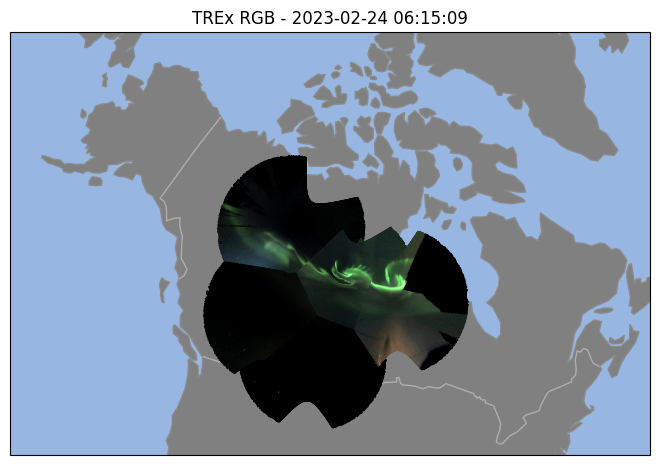

In [8]:
# plot mosaic
map_extent = [-145, -65, 35, 80]
mosaic.plot(map_extent, title="TREx RGB - %s" % (mosaic_dt.strftime("%Y-%m-%d %H:%M:%S")))